In [14]:
import time
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

mydata=pd.read_csv("/home/ubuntu/Notebooks/data/Gift_Cards.csv",names = ['item','user','rating','timestamp'])
mydata.head()
mydata.describe
list(mydata)
print(mydata)
del mydata['timestamp']
mydata.head()
df = mydata.copy()

              item            user  rating   timestamp
0       B001GXRQW0   APV13CM0919JD     1.0  1229644800
1       B001GXRQW0  A3G8U1G1V082SN     5.0  1229472000
2       B001GXRQW0   A11T2Q0EVTUWP     5.0  1229472000
3       B001GXRQW0   A9YKGBH3SV22C     5.0  1229472000
4       B001GXRQW0  A34WZIHVF3OKOL     1.0  1229472000
...            ...             ...     ...         ...
147189  B01H5PPJT4  A2K9WVQW9TLWNK     5.0  1536969600
147190  B01H5PPJT4  A149ALSR6TPGF7     4.0  1536278400
147191  B01H5PPJT4  A2Q066NZCQSCOR     5.0  1535500800
147192  B01H5PPJT4  A1KJLWCW7XBS8I     5.0  1534550400
147193  B01H5PPJT4   ANABUB0FRZXRM     5.0  1534204800

[147194 rows x 4 columns]


In [4]:
user_ids = df["user"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["item"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["user"] = df["user"].map(user2user_encoded)
df["item"] = df["item"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)
#df.head()

Number of users: 128877, Number of Items: 1548, Min rating: 1.0, Max rating: 5.0


In [5]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "item"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [7]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [8]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
2070/2070 [==============================] - 66s 32ms/step - loss: 0.4905 - val_loss: 0.3171
Epoch 2/5
2070/2070 [==============================] - 78s 37ms/step - loss: 0.2970 - val_loss: 0.4123
Epoch 3/5
2070/2070 [==============================] - 64s 31ms/step - loss: 0.2776 - val_loss: 0.4368
Epoch 4/5
2070/2070 [==============================] - 64s 31ms/step - loss: 0.2728 - val_loss: 0.4450
Epoch 5/5
2070/2070 [==============================] - 65s 31ms/step - loss: 0.2690 - val_loss: 0.4367


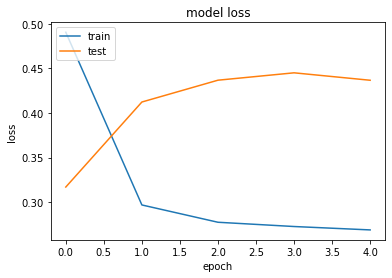

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [13]:
# Let us get a user and see the top recommendations.
# user 2853 has multiple ratings. good for demonstration
user_id = 2853
#user_id = df.user.sample(1).iloc[0]
#print(user_id)
movies_watched_by_user = df[df.user == user_id]
#print(movies_watched_by_user)
movies_not_watched = df[~df["item"].isin(movies_watched_by_user.item.values)]["item"]
#print(movies_not_watched)
movies_not_watched = list(set(movies_not_watched).intersection(set(item2item_encoded.keys())))
#print(movies_not_watched)
movies_not_watched = [[item2item_encoded.get(x)] for x in movies_not_watched]
#print(movies_not_watched)
user_encoder = user2user_encoded.get(user_id)
#print(user_encoder)
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
#print(user_movie_array)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

UnboundLocalError: local variable 'batch_outputs' referenced before assignment

In [11]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
#top 5 movies (in terms of the user's rating) watched by the user
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .item.values
)
print(top_movies_user)
movie_df_rows = df[df["user"]==user_id] # & df["item"].isin(top_movies_user)]
movie_df_rows.head(5)
for row in movie_df_rows.itertuples():
    print(row.item, ":", row.rating)

Showing recommendations for user: 2853
Movies with high ratings from user
--------------------------------
[38]
38 : 5.0


In [12]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = mydata[mydata["item"].isin(recommended_movie_ids)]
recommended_movies
#for row in recommended_movies.itertuples():
#    print(row.item, ":", row.rating)

--------------------------------
Top 10 movie recommendations
--------------------------------


NameError: name 'recommended_movie_ids' is not defined

In [10]:
# Let us get a user and see the top recommendations.
#user_id = df.user.sample(1).iloc[0]
user_id = 2853
movies_watched_by_user = df[df.user == user_id]
movies_watched_by_user
movies_not_watched = df[
    ~df["item"].isin(movies_watched_by_user.item.values)
]["item"]
movies_not_watched
movies_not_watched = list(
    set(movies_not_watched).intersection(set(item2item_encoded))
)
#print(movies_watched_by_user)
movies_not_watched
movies_not_watched = [[item2item_encoded.get(x)] for x in movies_not_watched]
movies_not_watched
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
user_movie_array
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    item_encoded2item.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print(recommended_movie_ids)
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
#recommended_movies = df[df["item"].isin(recommended_movie_ids)]
#for element in recommended_movie_ids:
#    print(row.item, ":", row.rating)
df[df["item"]==1261]

NameError: name 'model' is not defined

In [11]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

NameError: name 'movielens_dir' is not defined